In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [3]:
sys.path.insert(0, "../metapop")

from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)


In [70]:
selected_buildings = ['Allen Hospital', 'Harkness Pavilion', 'Milstein Hospital', 'Mschony', 'Presbyterian Hospital', "Rest"]
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}
building2id[5]     = "Rest"

def building2building(building):
    if building in selected_buildings:
        return building
    else:
        return "Rest"


counts_ward_df             = pd.read_csv(path_to_ward_counts, parse_dates=["date"])
counts_ward_df["building"] = counts_ward_df.apply(lambda x: x.ward.split("-")[1], axis=1)
counts_ward_df["building"] = counts_ward_df.apply(lambda x: building2building(x.building), axis=1)

counts_ward_df             = counts_ward_df.reset_index(drop=True)
buildings_df               = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()

date_start    = pd.to_datetime('2020-02-01')
date_end      = pd.to_datetime('2021-02-28')
dates         = pd.date_range(date_start, date_end)
Tdat          =  len(dates)

buildings_df  = buildings_df[buildings_df.date.isin(dates)]

A     = pd.pivot(buildings_df, index='building', columns='date', values='num_admitted')
D     = pd.pivot(buildings_df, index='building', columns='date', values='num_discharged')
H     = pd.pivot(buildings_df, index='building', columns='date', values='num_hospitalized')
tests = pd.pivot(buildings_df, index='building', columns='date', values='num_tested')

pop                     = H.mean(axis=1)
num_pop                 = len(pop)

building_names = pop.index

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_25078/1438482836.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buildings_df               = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()


In [254]:
buildings_df["building2"] = buildings_df.apply(lambda x: building2building(x.building), axis=1)
buildings_plt_df          = buildings_df.groupby(['date', 'building2']).sum().reset_index()
hosp_df                   = buildings_plt_df.groupby(['date']).sum().reset_index()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/2188095908.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buildings_plt_df          = buildings_df.groupby(['date', 'building2']).sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/2188095908.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_df                   = buildings_plt_df.groupby(['date']).sum().reset_index()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/2215520246.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_df   = buildings_plt_df.groupby(['date']).sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/2215520246.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_w_df = buildings_plt_df.groupby(['date']).sum().resample("W-Sun").sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/2215520246.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

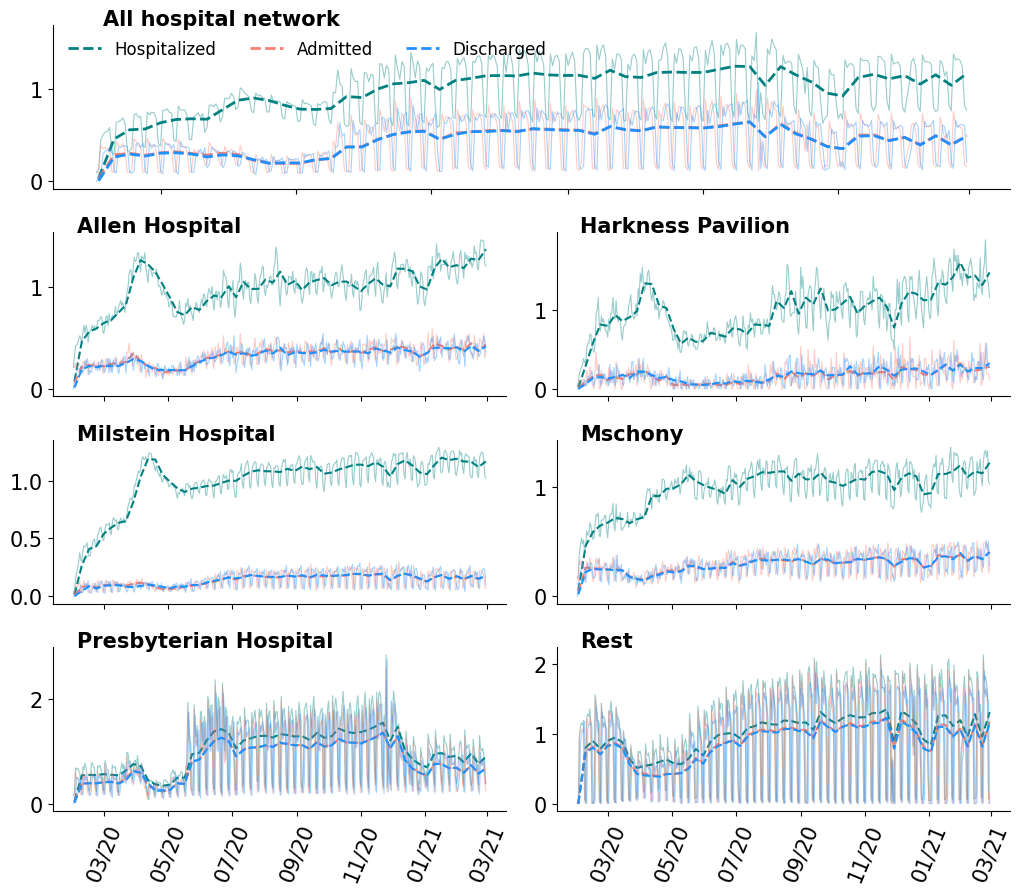

In [255]:
from matplotlib import dates as mdates
from utils_local import plot_utils
import matplotlib.pyplot as plt

H_ward_df     = pd.pivot(counts_ward_df,
                                index='ward', columns='date', values='num_hospitalized')

pop_ward                = np.clip(np.ceil(H_ward_df.mean(axis=1)), 1, None)
pop_ward_df             = pd.DataFrame(pop_ward, columns=["ward_size"]).reset_index()
pop_ward_df["building"] = pop_ward_df["ward"].apply(lambda x: x.split("-")[1])

layout = [["hospital", "hospital"],
          [selected_buildings[0],   selected_buildings[1]],
            [selected_buildings[2], selected_buildings[3]],
            [selected_buildings[4], selected_buildings[5]]]

fig, axes = plt.subplot_mosaic(layout,
                                figsize=(10.5, 9.2),
                                sharex=True, sharey=False)

hosp_df   = buildings_plt_df.groupby(['date']).sum().reset_index()
hosp_w_df = buildings_plt_df.groupby(['date']).sum().resample("W-Sun").sum().reset_index()

axes["hospital"].plot(hosp_df["date"],   hosp_df.num_hospitalized   / pop.sum(),     lw=0.8, alpha=0.4, color="teal")
axes["hospital"].plot(hosp_w_df["date"], hosp_w_df.num_hospitalized / (7*pop.sum()), lw=2, color="teal", ls="--", label="Hospitalized")

axes["hospital"].plot(hosp_df["date"],   hosp_df.num_admitted   /  pop.sum(),    lw=0.8, alpha=0.4, color="salmon")
axes["hospital"].plot(hosp_w_df["date"], hosp_w_df.num_admitted / (7*pop.sum()), lw=2, color="salmon", ls="--", label="Admitted")

axes["hospital"].plot(hosp_df["date"],   hosp_df.num_discharged  / pop.sum(),      lw=0.8, alpha=0.4, color="dodgerblue")
axes["hospital"].plot(hosp_w_df["date"], hosp_w_df.num_discharged/ (7* pop.sum()), lw=2, color="dodgerblue", ls="--", label="Discharged")

axes["hospital"].legend(loc="upper left", ncol=3, fontsize=12, frameon=False)
axes["hospital"].spines['right'].set_visible(False)
axes["hospital"].spines['top'].set_visible(False)
axes["hospital"].set_ylabel(None)
axes["hospital"].set_xlabel(None)

axes["hospital"].text(x         = 18296.0,
                    y          = axes["hospital"].get_ylim()[1],
                    s          = "All hospital network",
                    fontweight = "bold")

for idx_k, building in enumerate(selected_buildings):

    counts_ward_b_day_df = counts_ward_df[counts_ward_df.building == building]
    counts_ward_b_day_df.loc[:, "num_hospitalized_norm"] = counts_ward_b_day_df.apply(lambda x: x.num_hospitalized / pop_ward[x.ward], axis=1)
    counts_ward_b_day_df.loc[:, "num_discharged_norm"]   = counts_ward_b_day_df.apply(lambda x: x.num_discharged   / pop_ward[x.ward], axis=1)
    counts_ward_b_day_df.loc[:, "num_admitted_norm"]     = counts_ward_b_day_df.apply(lambda x: x.num_admitted     / pop_ward[x.ward], axis=1)

    counts_ward_b_wk_df                                 = counts_ward_b_day_df.set_index(["date", "ward"]).unstack([1])[["num_hospitalized", "num_admitted", "num_discharged"]].resample("W-Sun").sum().stack().reset_index()
    counts_ward_b_wk_df.loc[:, "num_hospitalized_norm"] = counts_ward_b_wk_df.apply(lambda x: x.num_hospitalized   / (7*pop_ward[x.ward]), axis=1)
    counts_ward_b_wk_df.loc[:, "num_discharged_norm"]   = counts_ward_b_wk_df.apply(lambda x: x.num_discharged / (7*pop_ward[x.ward]), axis=1)
    counts_ward_b_wk_df.loc[:, "num_admitted_norm"]     = counts_ward_b_wk_df.apply(lambda x: x.num_admitted   / (7*pop_ward[x.ward]), axis=1)

    b_df     = counts_ward_b_day_df.groupby(["date"])[["num_hospitalized", "num_admitted", "num_discharged"]].sum().reset_index()
    b_w_df   = counts_ward_b_day_df.groupby(["date"])[["num_hospitalized", "num_admitted", "num_discharged"]].sum().resample("W-Sun").sum().reset_index()

    pop_b_df = pop_ward_df[pop_ward_df.building == building]

    axes[building].plot(b_df["date"],   b_df.num_hospitalized   / pop[building],     lw=0.8, alpha=0.4, color="teal")
    axes[building].plot(b_w_df["date"], b_w_df.num_hospitalized / (7*pop[building]), lw=1.5, color="teal", ls="--", label="Hospitalized")

    axes[building].plot(b_df["date"],   b_df.num_admitted   /  pop[building],    lw=0.8, alpha=0.4, color="salmon")
    axes[building].plot(b_w_df["date"], b_w_df.num_admitted / (7*pop[building]), lw=1.5, color="salmon", ls="--", label="Admitted")

    axes[building].plot(b_df["date"],   b_df.num_discharged  / pop[building],      lw=0.8, alpha=0.4, color="dodgerblue")
    axes[building].plot(b_w_df["date"], b_w_df.num_discharged/ (7* pop[building]), lw=1.5, color="dodgerblue", ls="--", label="Discharged")

    axes[building].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    axes[building].tick_params(which='both', axis='x', labelrotation=67.5)

    if idx_k in [len(selected_buildings)-2, len(selected_buildings)-1]:
        axes[building].tick_params('x', labelbottom=True)

    #if building in selected_buildings[::2]:
    #    axes[building].legend(loc="upper left", ncol=2, fontsize=12, frameon=False)
    #else:
    #    axes[building].legend().remove()

    axes[building].legend().remove()
    axes[building].text(x         = 18296.0,
                        y          = axes[building].get_ylim()[1],
                        s          = building,
                        fontweight = "bold")

    axes[building].spines['right'].set_visible(False)
    axes[building].spines['top'].set_visible(False)
    axes[building].set_ylabel(None)
    axes[building].set_xlabel(None)

plt.tight_layout()


In [256]:
adm_rate_hosp = hosp_df.num_admitted / (7 * pop.sum())
print("Hospital level admission rate: {:.2f}, {:.2f}".format(np.round(adm_rate_hosp[4:].min() * 100), np.round(adm_rate_hosp[30:].max() * 100)))

d_rate_hosp = hosp_df.num_discharged / (7 * pop.sum())
print("Hospital level admission rate: {:.2f}, {:.2f}".format(np.round(d_rate_hosp[4:].min() * 100), np.round(d_rate_hosp[30:].max() * 100)))

Hospital level admission rate: 1.00, 14.00
Hospital level admission rate: 1.00, 15.00


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/3731583216.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  A_ward_df     = pd.pivot(counts_ward_df.set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index(),
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/3731583216.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  D_ward_df     = pd.pivot(counts_ward_df.set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index(),
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/3731583216.py:22: SettingWithCopyWarnin

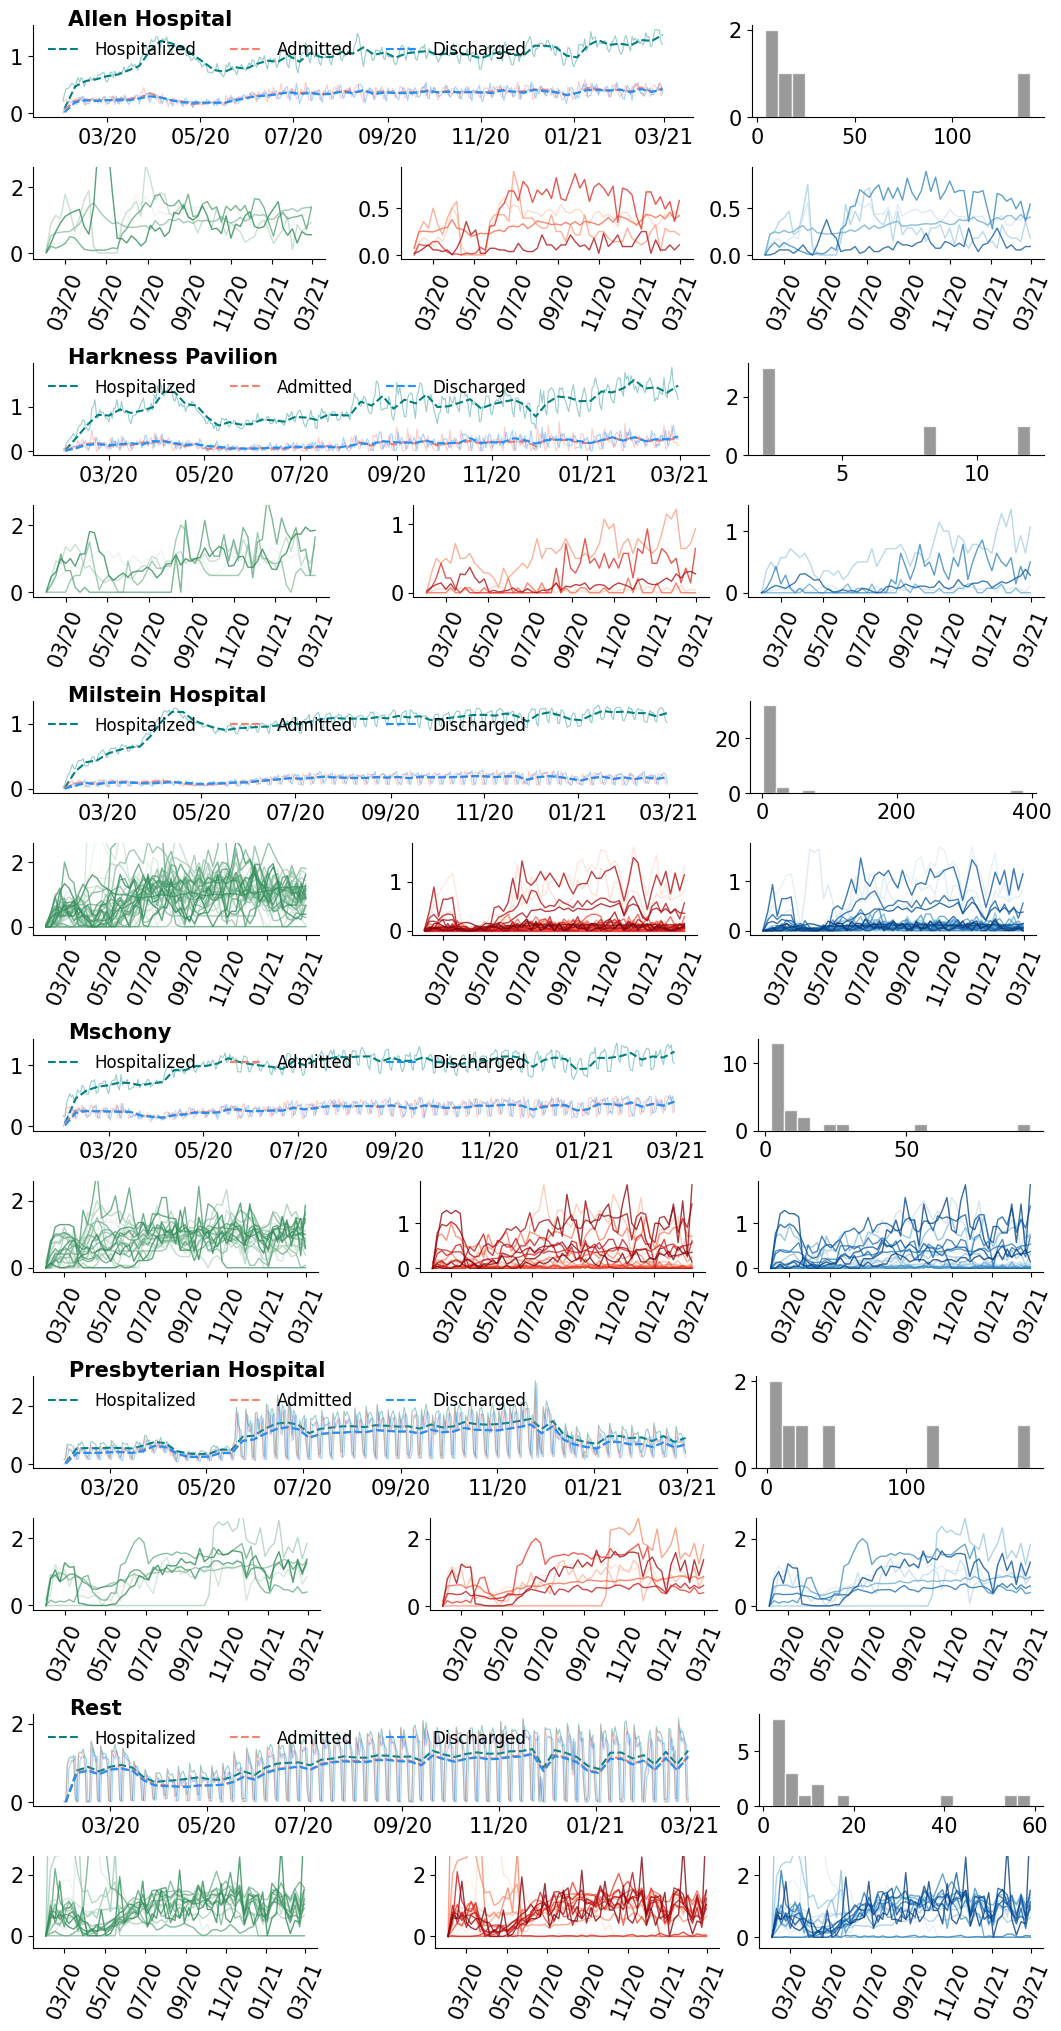

In [257]:
import seaborn as sns

A_ward_df     = pd.pivot(counts_ward_df.set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index(),
                                index='ward', columns='date', values='num_admitted')
D_ward_df     = pd.pivot(counts_ward_df.set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index(),
                                index='ward', columns='date', values='num_admitted')
H_ward_df     = pd.pivot(counts_ward_df,
                                index='ward', columns='date', values='num_hospitalized')

pop_ward                = np.clip(np.ceil(H_ward_df.mean(axis=1)), 1, None)
pop_ward_df             = pd.DataFrame(pop_ward, columns=["ward_size"]).reset_index()
pop_ward_df["building"] = pop_ward_df["ward"].apply(lambda x: x.split("-")[1])
pop_ward_df["building"] = pop_ward_df["building"].map(lambda x: building2building(x))

fig     = plt.figure(constrained_layout=True, figsize=(10.5, 20.2))

subfigs = fig.subfigures(len(selected_buildings), 1, hspace=0.02, wspace=0.1, height_ratios=[1/6]*len(selected_buildings))

for idx_building, building in enumerate(selected_buildings):
    counts_ward_b_day_df = counts_ward_df[counts_ward_df.building == building]

    counts_ward_b_day_df["num_hospitalized_norm"] = counts_ward_b_day_df.apply(lambda x: x.num_hospitalized / pop_ward[x.ward], axis=1)
    counts_ward_b_day_df["num_discharged_norm"]   = counts_ward_b_day_df.apply(lambda x: x.num_discharged   / pop_ward[x.ward], axis=1)
    counts_ward_b_day_df["num_admitted_norm"]     = counts_ward_b_day_df.apply(lambda x: x.num_admitted     / pop_ward[x.ward], axis=1)

    counts_ward_b_wk_df                                 = counts_ward_b_day_df.set_index(["date", "ward"]).unstack([1])[["num_hospitalized", "num_admitted", "num_discharged"]].resample("W-Sun").sum().stack().reset_index()
    counts_ward_b_wk_df.loc[:, "num_hospitalized_norm"] = counts_ward_b_wk_df.apply(lambda x: x.num_hospitalized   / (7*pop_ward[x.ward]), axis=1)
    counts_ward_b_wk_df.loc[:, "num_discharged_norm"]   = counts_ward_b_wk_df.apply(lambda x: x.num_discharged / (7*pop_ward[x.ward]), axis=1)
    counts_ward_b_wk_df.loc[:, "num_admitted_norm"]     = counts_ward_b_wk_df.apply(lambda x: x.num_admitted   / (7*pop_ward[x.ward]), axis=1)

    b_df     = counts_ward_b_day_df.groupby(["date"])[["num_hospitalized", "num_admitted", "num_discharged"]].sum().reset_index()
    b_w_df   = counts_ward_b_day_df.groupby(["date"])[["num_hospitalized", "num_admitted", "num_discharged"]].sum().resample("W-Sun").sum().reset_index()

    pop_b_df = pop_ward_df[pop_ward_df.building == building]

    axes = subfigs[idx_building].subplot_mosaic([["building", "building", "ward_size"],
                                                ["hospitalizations", "admissions", "discharges"]],
                                                sharex=False, sharey=False)

    axes["building"].plot(b_df["date"],   b_df.num_hospitalized   / pop[building],     lw=0.8, alpha=0.4, color="teal")
    axes["building"].plot(b_w_df["date"], b_w_df.num_hospitalized / (7*pop[building]), lw=1.5, color="teal", ls="--", label="Hospitalized")

    axes["building"].plot(b_df["date"],   b_df.num_admitted   /  pop[building],    lw=0.8, alpha=0.4, color="salmon")
    axes["building"].plot(b_w_df["date"], b_w_df.num_admitted / (7*pop[building]), lw=1.5, color="salmon", ls="--", label="Admitted")

    axes["building"].plot(b_df["date"],   b_df.num_discharged  / pop[building],      lw=0.8, alpha=0.4, color="dodgerblue")
    axes["building"].plot(b_w_df["date"], b_w_df.num_discharged/ (7* pop[building]), lw=1.5, color="dodgerblue", ls="--", label="Discharged")

    axes["ward_size"].hist(pop_b_df[pop_b_df.ward_size > 1].ward_size, bins=20, edgecolor="w", facecolor="gray", alpha=0.8)

    big_wards =  pop_b_df[pop_b_df.ward_size >=  2]["ward"]

    palette_hosp  = sns.light_palette("seagreen", n_colors=len(big_wards))
    palette_adms  = sns.color_palette("Reds",     n_colors=len(big_wards), desat=True)
    palette_disch = sns.color_palette("Blues",    n_colors=len(big_wards), desat=True)

    sns.lineplot(ax=axes["hospitalizations"], data=counts_ward_b_wk_df[counts_ward_b_wk_df.ward.isin(list(big_wards))],
                                                x="date", y="num_hospitalized_norm",  lw=1, alpha=0.8, hue="ward", palette=palette_hosp)
    sns.lineplot(ax=axes["admissions"],       data=counts_ward_b_wk_df[counts_ward_b_wk_df.ward.isin(list(big_wards))],
                                                x="date", y="num_admitted_norm",      lw=1, alpha=0.8, hue="ward", palette=palette_adms)
    sns.lineplot(ax=axes["discharges"],       data=counts_ward_b_wk_df[counts_ward_b_wk_df.ward.isin(list(big_wards))],
                                                x="date", y="num_discharged_norm",    lw=1, alpha=0.8, hue="ward", palette=palette_disch)

    axes["building"].text(x        = 18296.0,
                        y          = axes["building"].get_ylim()[1],
                        s          = building,
                        fontweight = "bold")
    axes["building"].legend(loc="upper left",
                            ncol     = 3,
                            fontsize = 12,
                            frameon  = False)

    for k in axes:
        axes[k].spines['right'].set_visible(False)
        axes[k].spines['top'].set_visible(False)
        axes[k].set_ylabel(None)
        axes[k].set_xlabel(None)

        if k == "ward_size":
            #axes[k].set_xlabel("ward size")
            continue
        axes[k].tick_params(which='both', axis='x', labelrotation=67.5)
        axes[k].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

        if k == "building":
            axes[k].tick_params(which='both', axis='x', labelrotation=0)
            continue

        axes[k].legend().remove()
        axes[k].set_ylim((axes[k].get_ylim()[0], np.minimum(2.6, axes[k].get_ylim()[1])))
    #plt.tight_layout()


# average time in hospital at different spatial scales

In [ ]:
def corr_lag(df, col1="num_admitted", col2="num_discharged", lags=np.arange(-20, 0)):
    corr = np.full(len(lags), np.nan)
    for idx_l, lag in enumerate(lags):
        df_lag       = df.copy()
        df_lag[col2] = df_lag[col2].shift(periods=lag)
        corr[idx_l]  = df_lag.corr().loc[col1][col2]
    return pd.DataFrame({"lag": lags, "correlation": corr})

In [98]:
hosp_df             = pd.read_csv(path_to_ward_counts, parse_dates=["date"])
hosp_df["building"] = hosp_df["ward"].map(lambda x: building2building(x.split("-")[1]))


In [143]:
corr_df                  = corr_lag(hosp_df.drop(columns=["ward"]).groupby(["date"]).sum(), col1="num_admitted", col2="num_discharged", lags=np.arange(-20, 0+1))
corr_df["spatial_scale"] = "hospital"


lag_resume_df = pd.DataFrame(columns=["lag_max", "corr_max", "spatial_scale", "building", "ward"])

for building in selected_buildings:
    b_df                   = hosp_df[hosp_df.building==building].groupby(["date"])[["num_admitted", "num_discharged"]].sum()

    cb_df                  = corr_lag(b_df, col1="num_admitted", col2="num_discharged", lags=np.arange(-20, 0+1))
    cb_df["spatial_scale"] = "building"
    cb_df["building"]      = building

    lag_max  = cb_df.lag[np.argmax(cb_df.correlation)]
    corr_max = np.max(cb_df.correlation)

    lag_resume_df = pd.concat([lag_resume_df, pd.DataFrame({"lag_max": [lag_max], "corr_max": [corr_max],
                                                            "spatial_scale": ["building"], "building": [building] })])
    corr_df        = pd.concat([corr_df, cb_df])

for ward in hosp_df.ward.unique():
    w_df                   = hosp_df[hosp_df.ward==ward].groupby(["date"])[["num_admitted", "num_discharged"]].sum()
    cw_df                  = corr_lag(w_df, col1="num_admitted", col2="num_discharged", lags=np.arange(-20, 0+1))
    cw_df["spatial_scale"] = "ward"
    cw_df["building"]      = building2building(ward.split("-")[1])
    cw_df["ward"]          = ward

    if np.argmax(cw_df.correlation)!=-1:
        lag_max  = cw_df.lag[np.argmax(cw_df.correlation)]
        corr_max = np.max(cw_df.correlation)
        lag_resume_df = pd.concat([lag_resume_df, pd.DataFrame({"lag_max": [lag_max], "corr_max": [corr_max],
                                                                "spatial_scale": ["ward"], "ward": [ward],
                                                                "building": [building2building(ward.split("-")[1])]
                                                                })])

    corr_df       = pd.concat([corr_df, cw_df])



/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_25078/2687761234.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corr_df                  = corr_lag(hosp_df.drop(columns=["ward"]).groupby(["date"]).sum(), col1="num_admitted", col2="num_discharged", lags=np.arange(-20, 0+1))


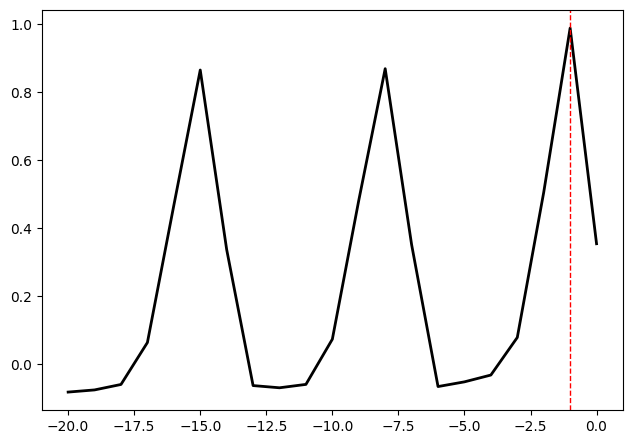

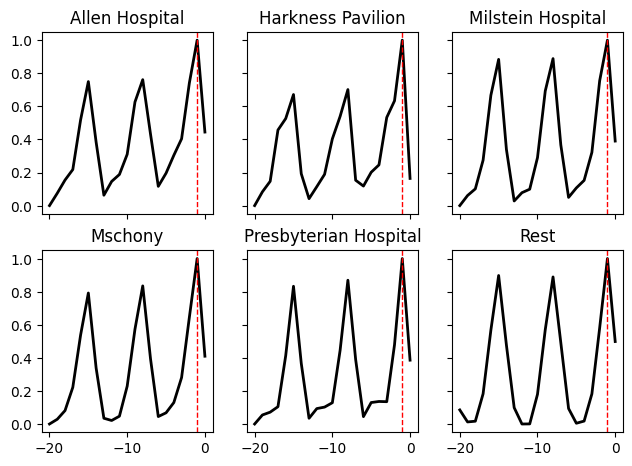

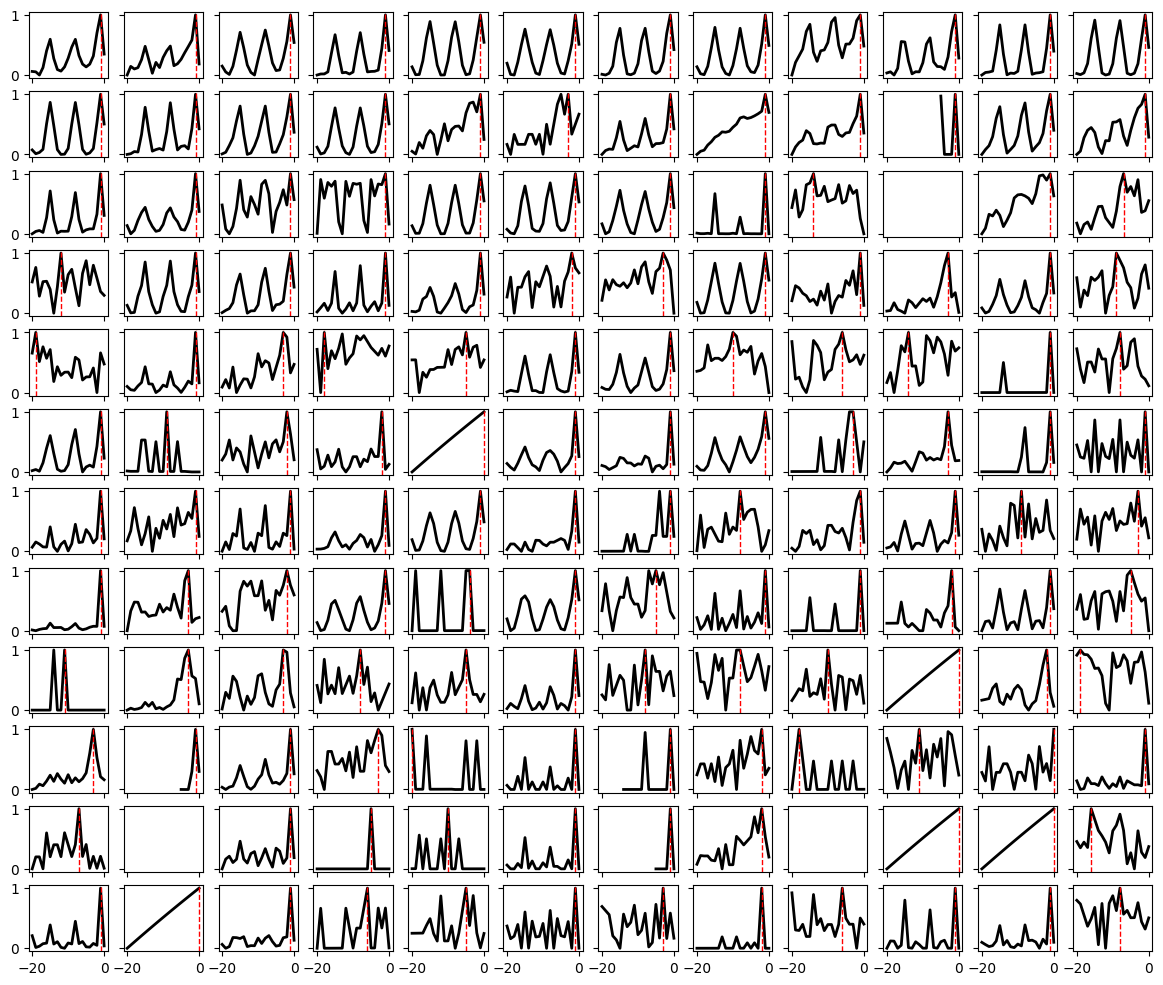

In [144]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.2))
ax.plot(corr_df[corr_df.spatial_scale=="hospital"].lag,
            corr_df[corr_df.spatial_scale=="hospital"].correlation, color="k", lw=2)

lag_max   = corr_df[corr_df.spatial_scale=="hospital"].lag[np.argmax(corr_df[corr_df.spatial_scale=="hospital"].correlation)]
ax.axvline(x=lag_max, color="r", linestyle="--", lw=1)


fig, axes = plt.subplots(2, 3, figsize=(7.5, 5.2), sharex=True, sharey=True)
for idx_ax, ax in enumerate(axes.flatten()):
    bc_df   = corr_df[corr_df.building==selected_buildings[idx_ax]]
    norm_corr = bc_df.correlation - np.min(bc_df.correlation)
    norm_corr = norm_corr/(np.max(bc_df.correlation)-np.min(bc_df.correlation))

    ax.plot(bc_df.lag, norm_corr, color="k", lw=2)
    ax.set_title(selected_buildings[idx_ax])

    lag_max = bc_df.lag[np.argmax(norm_corr)]
    ax.axvline(x=lag_max, color="r", linestyle="--", lw=1)

wards     = hosp_df.ward.unique()

fig, axes = plt.subplots(12, 12, figsize=(14.5, 12.2), sharex=True, sharey=True)
for idx_ax, ax in enumerate(axes.flatten()):
    wc_df    = corr_df[corr_df.ward==wards[idx_ax]]
    norm_corr = wc_df.correlation - np.min(wc_df.correlation)
    norm_corr = norm_corr/(np.max(wc_df.correlation)-np.min(wc_df.correlation))

    ax.plot(wc_df.lag, norm_corr, color="k", lw=2)

    if np.argmax(norm_corr)!=-1:
        lag_max = wc_df.lag[np.argmax(norm_corr)]
        ax.axvline(x=lag_max, color="r", linestyle="--", lw=1)


<BarContainer object of 20 artists>

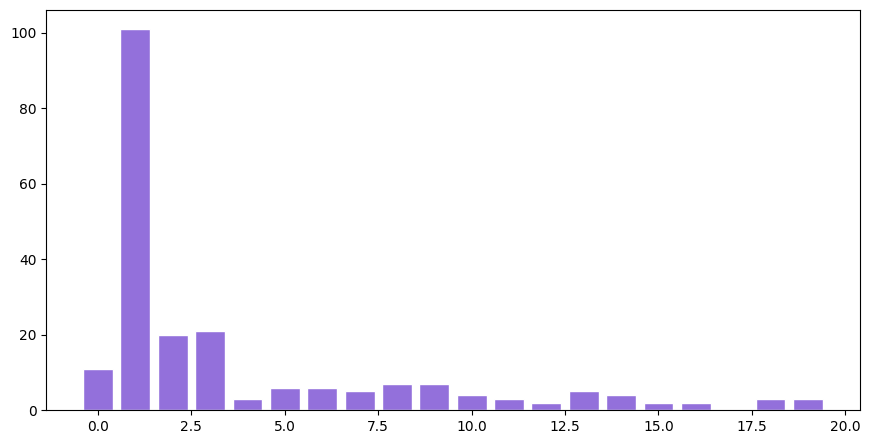

In [172]:
lag_resume_df

fig, ax = plt.subplots(1, 1, figsize=(10.5, 5.2))

count, bins = np.histogram(-lag_resume_df["lag_max"], bins=np.arange(0, 20+1))
ax.bar(bins[:-1], count, facecolor="mediumpurple", edgecolor="w", width=0.8)
